## Exploring patterns in data

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.insert(0, parent_dir)

from utilities.gan_plotting import extensive_plotting
from utilities.backtesting_plots import backtest_var_single_asset
from utilities.gan_plotting import load_generated_returns
from backtesting.perform_var_tests import perform_var_backtesting_tests
from backtesting.perform_distribution_tests import perform_distribution_tests
from utilities.gan_plotting import create_rolling_empirical


In [2]:
def fetch_data_df():
    # Load the data
    df = pd.read_csv('../../data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = os.getenv("START_TEST_DATE")
    
    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)

    columns = [0,1,2,4, 5, 6]
    selected_columns = df.iloc[:, columns]  # Remember: Python uses 0-based indexing

    pre_test_df = selected_columns[selected_columns.index < start_test_date]
    test_df = selected_columns[selected_columns.index >= start_test_date].iloc[:252]
    
    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()


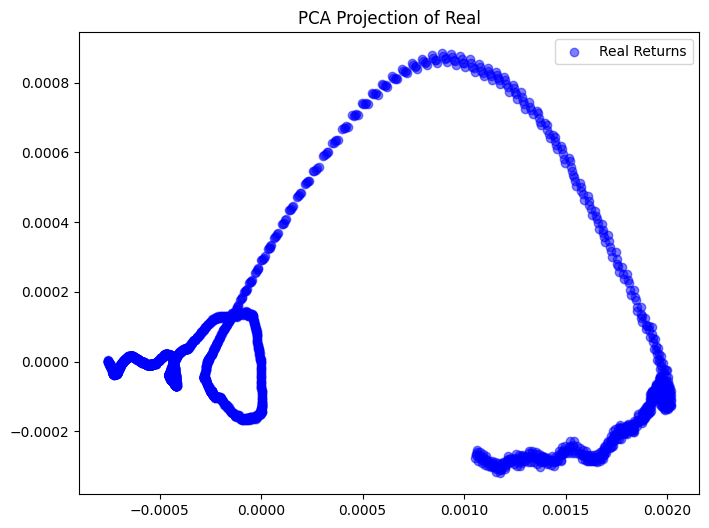

In [3]:

def create_rolling_empirical(returns_df, window_size=252):
    """Creates rolling 1-year (252-day) sequences from empirical data"""
    rolling_data = []
    for i in range(len(returns_df) - window_size):
        window = returns_df[i : i + window_size]
        rolling_data.append(window)
    return np.array(rolling_data)

precomputed_rolling_returns = {asset: create_rolling_empirical(returns_df[asset].values) for asset in returns_df.columns}
real_returns = precomputed_rolling_returns['EONIA']
real_returns = np.nan_to_num(real_returns, nan=np.nanmedian(real_returns))


#generated_returns = np.nan_to_num(generated_returns, nan=np.nanmedian(generated_returns))

# PCA Projection for real vs generated data
pca = PCA(n_components=2)

real_pca = pca.fit_transform(real_returns)

plt.figure(figsize=(8, 6))
plt.scatter(real_pca[:, 0], real_pca[:, 1], color="blue", label="Real Returns", alpha=0.5)
plt.legend()
plt.title("PCA Projection of Real")
plt.show()

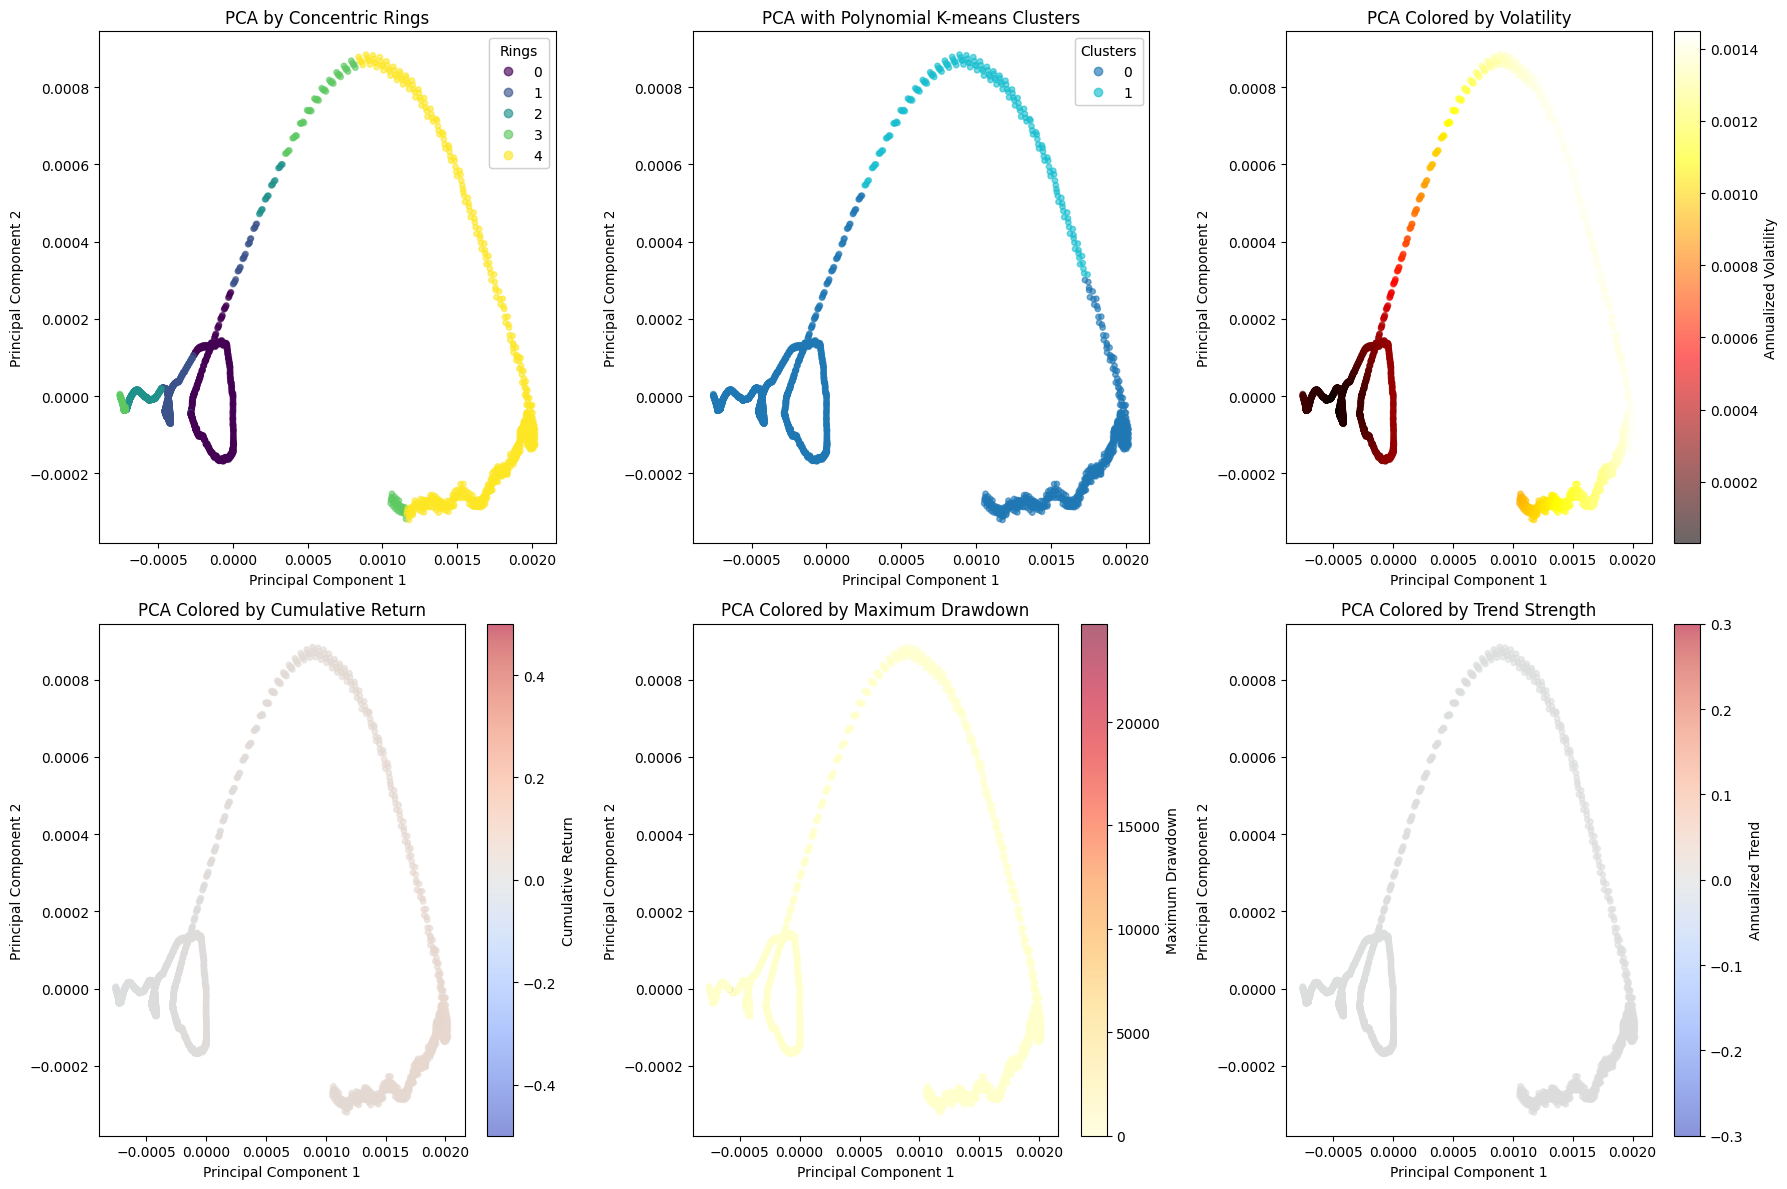

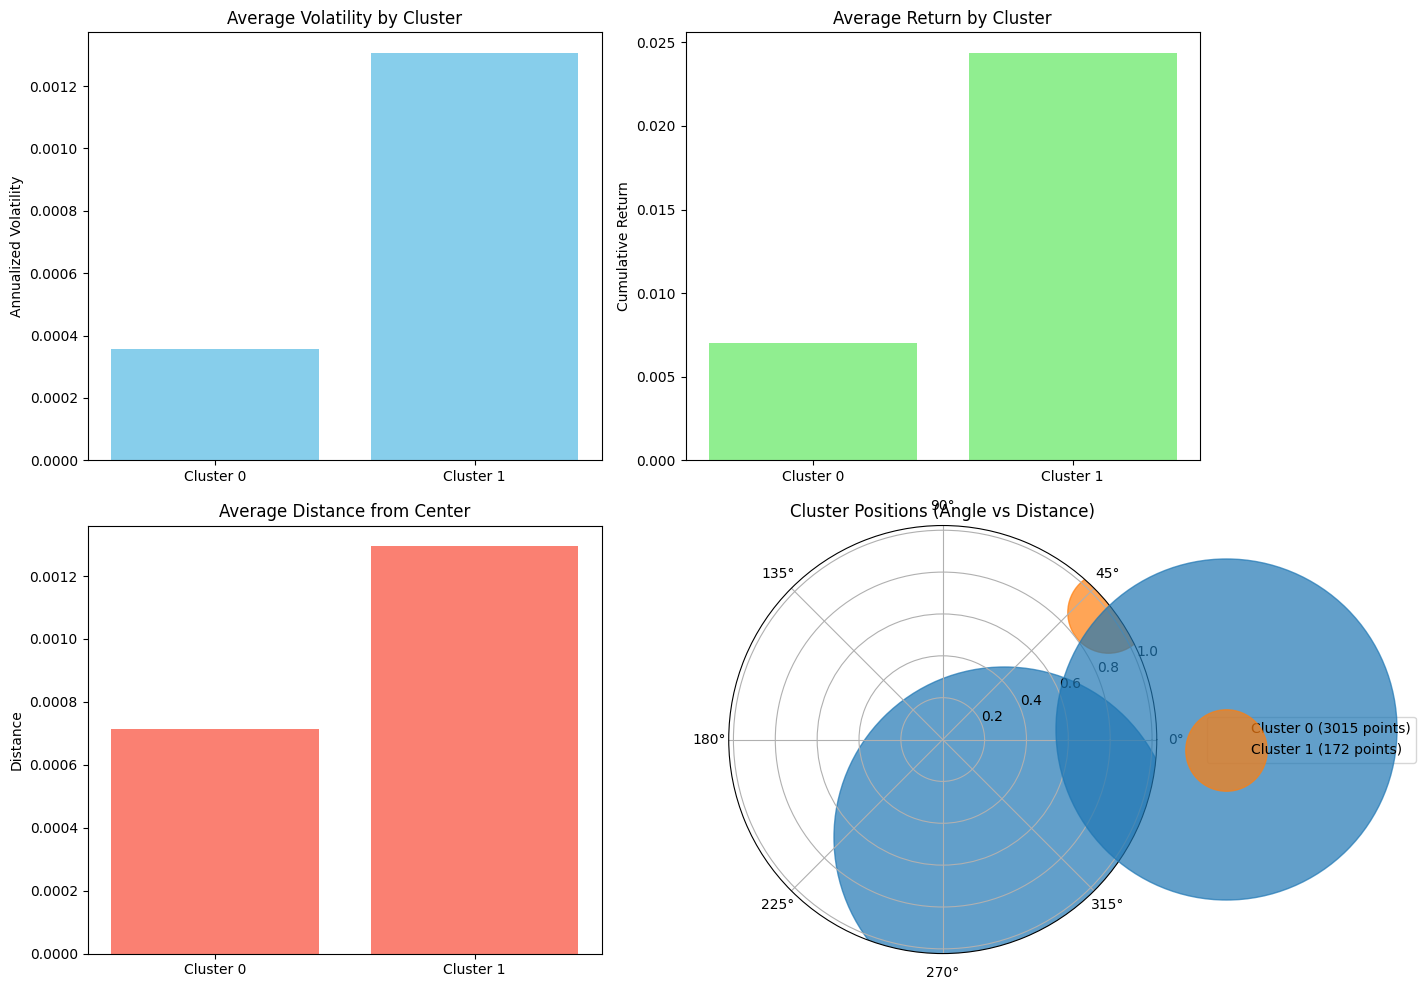

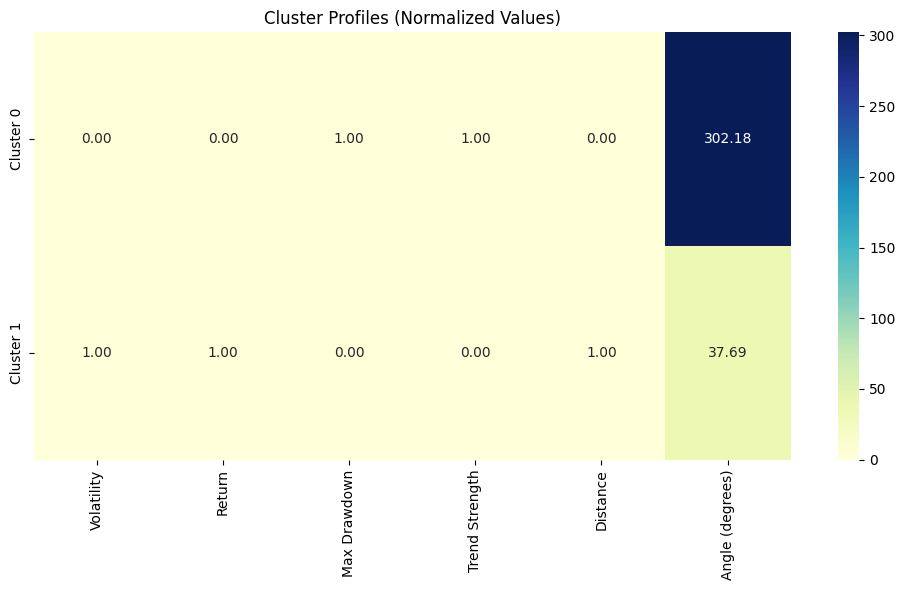

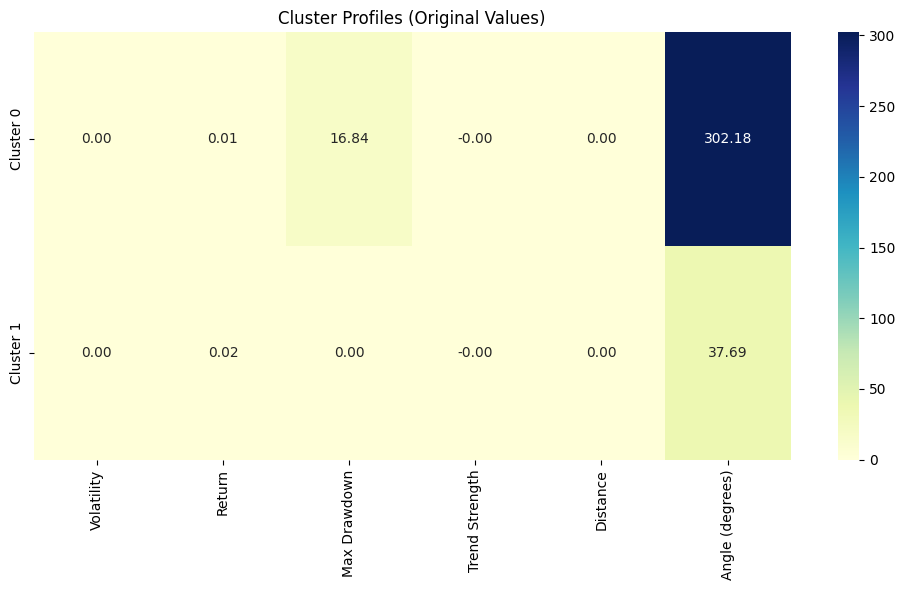

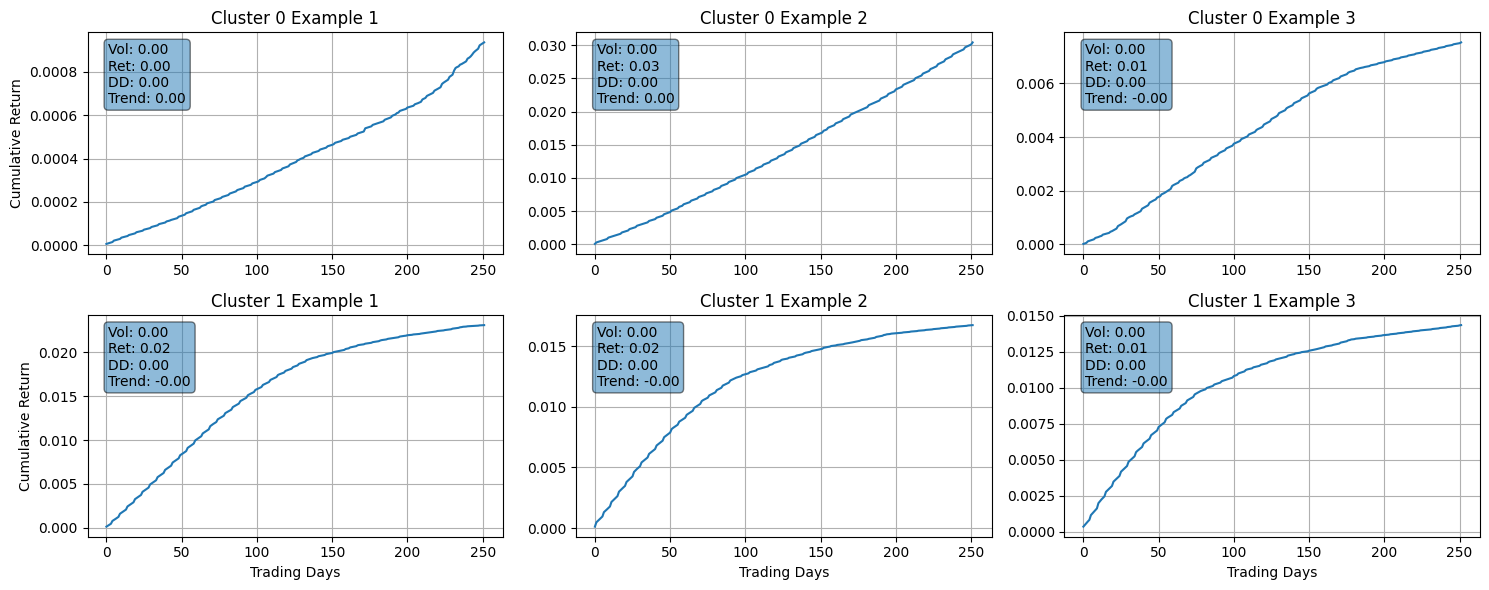


==== RING ANALYSIS (REFERENCE) ====

Inner Core (638 windows):
  Average Volatility: 0.0003
  Average Return: 0.0057
  Average Max Drawdown: 0.0000
  Average Trend: -0.0000

Ring 1 (637 windows):
  Average Volatility: 0.0001
  Average Return: 0.0016
  Average Max Drawdown: 0.0166
  Average Trend: -0.0000

Ring 2 (637 windows):
  Average Volatility: 0.0001
  Average Return: -0.0016
  Average Max Drawdown: 79.6681
  Average Trend: -0.0000

Ring 3 (637 windows):
  Average Volatility: 0.0003
  Average Return: -0.0003
  Average Max Drawdown: 0.0000
  Average Trend: -0.0000

Outer Ring (638 windows):
  Average Volatility: 0.0013
  Average Return: 0.0344
  Average Max Drawdown: 0.0000
  Average Trend: -0.0000

==== POLYNOMIAL K-MEANS CLUSTER ANALYSIS ====

Cluster 0 (3015 windows):
  Average Volatility: 0.0004
  Average Return: 0.0070
  Average Max Drawdown: 16.8355
  Average Trend: -0.0000
  Average Distance from Center: 0.0007
  Average Angle (degrees): 302.2

Cluster 1 (172 windows):
  Av

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import seaborn as sns

def analyze_with_polynomial_kmeans(real_pca, real_returns, n_clusters=5, polynomial_degree=2):
    """
    Analyze PCA data using polynomial features and K-means clustering
    
    Parameters:
    -----------
    real_pca : numpy.ndarray
        The PCA projection of shape (n_samples, 2)
    real_returns : numpy.ndarray
        The original rolling returns data of shape (n_samples, window_size)
    n_clusters : int
        Number of clusters for K-means
    polynomial_degree : int
        Degree of polynomial transformation
        
    Returns:
    --------
    dict
        Dictionary containing analysis results
    """
    results = {}
    
    # Calculate polar coordinates for reference
    distances = np.sqrt(real_pca[:, 0]**2 + real_pca[:, 1]**2)
    angles = np.arctan2(real_pca[:, 1], real_pca[:, 0])
    
    results['distances'] = distances
    results['angles'] = angles
    
    # Create polynomial features for better capturing circular patterns
    poly = PolynomialFeatures(degree=polynomial_degree, include_bias=False)
    poly_features = poly.fit_transform(real_pca)
    
    # Standardize the polynomial features for better clustering
    scaler = StandardScaler()
    poly_features_scaled = scaler.fit_transform(poly_features)
    
    # Apply K-means to the polynomial features
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(poly_features_scaled)
    
    results['cluster_labels'] = cluster_labels
    results['poly_features'] = poly_features
    
    # Create ring labels for comparison (5 rings)
    percentiles = [20, 40, 60, 80]
    thresholds = [np.percentile(distances, p) for p in percentiles]
    
    ring_labels = np.zeros(len(distances), dtype=int)
    for i, threshold in enumerate(thresholds):
        if i == 0:
            ring_labels[distances <= threshold] = 0
        else:
            ring_labels[(distances > thresholds[i-1]) & 
                       (distances <= threshold)] = i
    
    ring_labels[distances > thresholds[-1]] = len(thresholds)
    results['ring_labels'] = ring_labels
    
    # Calculate financial characteristics for each window
    window_metrics = []
    for window in real_returns:
        cumulative = np.cumsum(window)
        
        # Volatility (annualized)
        vol = np.std(window) * np.sqrt(252)
        
        # Final return
        final_return = cumulative[-1]
        
        # Maximum drawdown
        peak = np.maximum.accumulate(cumulative)
        drawdowns = np.zeros_like(cumulative)
        for i in range(len(cumulative)):
            if peak[i] > 0:
                drawdowns[i] = (peak[i] - cumulative[i]) / peak[i]
        max_drawdown = np.max(drawdowns) if len(drawdowns) > 0 else 0
        
        # Trend strength (slope of linear regression)
        x = np.arange(len(window))
        cov = np.cov(x, window)[0, 1]
        var = np.var(x)
        trend = cov / var if var != 0 else 0
        trend_annualized = trend * 252  # Annualize
        
        # Skewness and kurtosis
        skew = np.mean(((window - np.mean(window)) / np.std(window)) ** 3) if np.std(window) > 0 else 0
        kurt = np.mean(((window - np.mean(window)) / np.std(window)) ** 4) if np.std(window) > 0 else 3
        
        window_metrics.append({
            'volatility': vol,
            'final_return': final_return,
            'max_drawdown': max_drawdown,
            'trend': trend_annualized,
            'skewness': skew,
            'kurtosis': kurt
        })
    
    metrics_df = pd.DataFrame(window_metrics)
    results['metrics'] = metrics_df
    
    # Analyze metrics by cluster
    cluster_analysis = {}
    for i in range(n_clusters):
        cluster_metrics = metrics_df.iloc[cluster_labels == i]
        
        # Get mean distance and angle for this cluster
        cluster_distances = distances[cluster_labels == i]
        cluster_angles = angles[cluster_labels == i]
        
        # Convert angles to degrees for easier interpretation
        mean_angle_degrees = np.degrees(np.mean(cluster_angles)) % 360
        
        cluster_analysis[f'Cluster {i}'] = {
            'count': len(cluster_metrics),
            'avg_volatility': cluster_metrics['volatility'].mean(),
            'avg_return': cluster_metrics['final_return'].mean(),
            'avg_drawdown': cluster_metrics['max_drawdown'].mean(),
            'avg_trend': cluster_metrics['trend'].mean(),
            'avg_skewness': cluster_metrics['skewness'].mean(),
            'avg_kurtosis': cluster_metrics['kurtosis'].mean(),
            'avg_distance': np.mean(cluster_distances),
            'avg_angle_degrees': mean_angle_degrees
        }
    
    results['cluster_analysis'] = cluster_analysis
    
    # Analyze metrics by ring (for comparison)
    ring_analysis = {}
    for i in range(len(thresholds) + 1):
        ring_name = 'Inner Core' if i == 0 else f'Ring {i}'
        if i == len(thresholds):
            ring_name = 'Outer Ring'
            
        ring_metrics = metrics_df.iloc[ring_labels == i]
        ring_analysis[ring_name] = {
            'count': len(ring_metrics),
            'avg_volatility': ring_metrics['volatility'].mean(),
            'avg_return': ring_metrics['final_return'].mean(),
            'avg_drawdown': ring_metrics['max_drawdown'].mean(),
            'avg_trend': ring_metrics['trend'].mean(),
            'avg_skewness': ring_metrics['skewness'].mean(),
            'avg_kurtosis': ring_metrics['kurtosis'].mean()
        }
    
    results['ring_analysis'] = ring_analysis
    
    return results

def plot_polynomial_kmeans(real_pca, analysis_results):
    """
    Plot the results of polynomial K-means analysis
    """
    metrics = analysis_results['metrics']
    
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    
    # Plot 1: PCA colored by rings
    scatter = axs[0, 0].scatter(real_pca[:, 0], real_pca[:, 1], 
                          c=analysis_results['ring_labels'], 
                          cmap='viridis', alpha=0.6, s=15)
    axs[0, 0].set_title('PCA by Concentric Rings')
    legend1 = axs[0, 0].legend(*scatter.legend_elements(),
                         loc="upper right", title="Rings")
    axs[0, 0].add_artist(legend1)
    axs[0, 0].set_xlabel('Principal Component 1')
    axs[0, 0].set_ylabel('Principal Component 2')
    
    # Plot 2: PCA colored by polynomial K-means clusters
    scatter = axs[0, 1].scatter(real_pca[:, 0], real_pca[:, 1], 
                          c=analysis_results['cluster_labels'], 
                          cmap='tab10', alpha=0.6, s=15)
    axs[0, 1].set_title('PCA with Polynomial K-means Clusters')
    legend2 = axs[0, 1].legend(*scatter.legend_elements(),
                        loc="upper right", title="Clusters")
    axs[0, 1].add_artist(legend2)
    axs[0, 1].set_xlabel('Principal Component 1')
    axs[0, 1].set_ylabel('Principal Component 2')
    
    # Plot 3: PCA colored by volatility
    scatter = axs[0, 2].scatter(real_pca[:, 0], real_pca[:, 1], 
                          c=metrics['volatility'], 
                          cmap='hot', alpha=0.6, s=15)
    axs[0, 2].set_title('PCA Colored by Volatility')
    cbar = plt.colorbar(scatter, ax=axs[0, 2])
    cbar.set_label('Annualized Volatility')
    axs[0, 2].set_xlabel('Principal Component 1')
    axs[0, 2].set_ylabel('Principal Component 2')
    
    # Plot 4: PCA colored by returns
    scatter = axs[1, 0].scatter(real_pca[:, 0], real_pca[:, 1], 
                          c=metrics['final_return'], 
                          cmap='coolwarm', alpha=0.6, s=15,
                          vmin=-0.5, vmax=0.5)  # Adjust as needed
    axs[1, 0].set_title('PCA Colored by Cumulative Return')
    cbar = plt.colorbar(scatter, ax=axs[1, 0])
    cbar.set_label('Cumulative Return')
    axs[1, 0].set_xlabel('Principal Component 1')
    axs[1, 0].set_ylabel('Principal Component 2')
    
    # Plot 5: PCA colored by drawdown
    scatter = axs[1, 1].scatter(real_pca[:, 0], real_pca[:, 1], 
                          c=metrics['max_drawdown'], 
                          cmap='YlOrRd', alpha=0.6, s=15)
    axs[1, 1].set_title('PCA Colored by Maximum Drawdown')
    cbar = plt.colorbar(scatter, ax=axs[1, 1])
    cbar.set_label('Maximum Drawdown')
    axs[1, 1].set_xlabel('Principal Component 1')
    axs[1, 1].set_ylabel('Principal Component 2')
    
    # Plot 6: PCA colored by trend
    scatter = axs[1, 2].scatter(real_pca[:, 0], real_pca[:, 1], 
                          c=metrics['trend'], 
                          cmap='coolwarm', alpha=0.6, s=15,
                          vmin=-0.3, vmax=0.3)  # Adjust as needed
    axs[1, 2].set_title('PCA Colored by Trend Strength')
    cbar = plt.colorbar(scatter, ax=axs[1, 2])
    cbar.set_label('Annualized Trend')
    axs[1, 2].set_xlabel('Principal Component 1')
    axs[1, 2].set_ylabel('Principal Component 2')
    
    plt.tight_layout()
    plt.show()
    
    return fig

def plot_cluster_metrics(analysis_results, n_clusters=5):
    """
    Plot key metrics for each polynomial K-means cluster
    """
    cluster_analysis = analysis_results['cluster_analysis']
    
    # Extract data for plotting
    clusters = []
    volatilities = []
    returns = []
    drawdowns = []
    trends = []
    distances = []
    angles = []
    counts = []
    
    for name, metrics in cluster_analysis.items():
        cluster = int(name.split()[1])
        clusters.append(cluster)
        volatilities.append(metrics['avg_volatility'])
        returns.append(metrics['avg_return'])
        drawdowns.append(metrics['avg_drawdown'])
        trends.append(metrics['avg_trend'])
        distances.append(metrics['avg_distance'])
        angles.append(metrics['avg_angle_degrees'])
        counts.append(metrics['count'])
    
    # Create a figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    
    cluster_names = [f'Cluster {i}' for i in range(n_clusters)]
    
    # Plot volatility by cluster
    axs[0, 0].bar(cluster_names, volatilities, color='skyblue')
    axs[0, 0].set_title('Average Volatility by Cluster')
    axs[0, 0].set_ylabel('Annualized Volatility')
    
    # Plot returns by cluster
    axs[0, 1].bar(cluster_names, returns, color='lightgreen')
    axs[0, 1].set_title('Average Return by Cluster')
    axs[0, 1].set_ylabel('Cumulative Return')
    
    # Plot distance by cluster
    axs[1, 0].bar(cluster_names, distances, color='salmon')
    axs[1, 0].set_title('Average Distance from Center')
    axs[1, 0].set_ylabel('Distance')
    
    # Plot angles by cluster (polar plot)
    axs[1, 1].remove()  # Remove the existing axes
    ax_polar = fig.add_subplot(224, polar=True)
    
    # Convert angles to radians for polar plot
    angles_rad = np.deg2rad(angles)
    
    # Use distances as radii (normalized to [0,1])
    radii = np.array(distances) / max(distances) if max(distances) > 0 else np.ones_like(distances)
    
    # Use a colormap for the points
    colors = plt.cm.tab10(np.array(clusters) % 10)
    
    # Plot the points on the polar axis
    for i, (angle, radius) in enumerate(zip(angles_rad, radii)):
        ax_polar.scatter(angle, radius, s=counts[i]*20, color=colors[i], alpha=0.7, 
                         label=f'Cluster {clusters[i]} ({counts[i]} points)')
    
    ax_polar.set_title('Cluster Positions (Angle vs Distance)')
    ax_polar.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
    
    plt.tight_layout()
    plt.show()
    
    return fig

def create_cluster_profile_heatmap(analysis_results, n_clusters=5):
    """
    Create a heatmap to visualize the profile of each cluster
    """
    cluster_analysis = analysis_results['cluster_analysis']
    
    # Extract relevant metrics for the heatmap
    metrics = ['avg_volatility', 'avg_return', 'avg_drawdown', 'avg_trend', 
               'avg_distance', 'avg_angle_degrees']
    
    metric_names = ['Volatility', 'Return', 'Max Drawdown', 'Trend Strength', 
                   'Distance', 'Angle (degrees)']
    
    # Create a DataFrame for the heatmap
    heatmap_data = []
    for i in range(n_clusters):
        cluster_metrics = cluster_analysis[f'Cluster {i}']
        row = [cluster_metrics[metric] for metric in metrics]
        heatmap_data.append(row)
    
    heatmap_df = pd.DataFrame(heatmap_data, 
                             index=[f'Cluster {i}' for i in range(n_clusters)],
                             columns=metric_names)
    
    # Normalize the data for better visualization
    for col in heatmap_df.columns:
        if col != 'Angle (degrees)':  # Don't normalize angles
            heatmap_df[col] = (heatmap_df[col] - heatmap_df[col].min()) / (heatmap_df[col].max() - heatmap_df[col].min())
    
    # Create the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_df, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title('Cluster Profiles (Normalized Values)')
    plt.tight_layout()
    plt.show()
    
    # Now create a non-normalized version with original values
    heatmap_data = []
    for i in range(n_clusters):
        cluster_metrics = cluster_analysis[f'Cluster {i}']
        row = [cluster_metrics[metric] for metric in metrics]
        heatmap_data.append(row)
    
    heatmap_df = pd.DataFrame(heatmap_data, 
                             index=[f'Cluster {i}' for i in range(n_clusters)],
                             columns=metric_names)
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_df, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title('Cluster Profiles (Original Values)')
    plt.tight_layout()
    plt.show()
    
    return heatmap_df

def plot_example_windows(real_returns, analysis_results, num_examples=3):
    """
    Plot example windows from each cluster
    """
    cluster_labels = analysis_results['cluster_labels']
    
    # Get unique cluster labels
    unique_clusters = np.unique(cluster_labels)
    num_clusters = len(unique_clusters)
    
    fig, axs = plt.subplots(num_clusters, num_examples, figsize=(15, 3*num_clusters))
    
    for i, cluster in enumerate(unique_clusters):
        # Get indices for this cluster
        indices = np.where(cluster_labels == cluster)[0]
        
        # Choose random examples
        if len(indices) > 0:
            sample_indices = np.random.choice(indices, min(num_examples, len(indices)), replace=False)
            
            for j, sample_idx in enumerate(sample_indices):
                window = real_returns[sample_idx]
                cumulative = np.cumsum(window)
                
                if num_clusters > 1:
                    if num_examples > 1:
                        ax = axs[i, j]
                    else:
                        ax = axs[i]
                else:
                    ax = axs[j]
                    
                ax.plot(cumulative)
                ax.set_title(f'Cluster {cluster} Example {j+1}')
                ax.grid(True)
                
                # Add metrics as text
                metrics = analysis_results['metrics'].iloc[sample_idx]
                metrics_text = (f"Vol: {metrics['volatility']:.2f}\n"
                               f"Ret: {metrics['final_return']:.2f}\n"
                               f"DD: {metrics['max_drawdown']:.2f}\n"
                               f"Trend: {metrics['trend']:.2f}")
                ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, 
                        verticalalignment='top', bbox={'boxstyle': 'round', 'alpha': 0.5})
                
                if i == num_clusters-1:  # Last row
                    ax.set_xlabel('Trading Days')
                
                if j == 0:  # First column
                    ax.set_ylabel('Cumulative Return')
    
    plt.tight_layout()
    plt.show()
    
    return fig

def print_analysis_summary(results, n_clusters=5):
    """Print a summary of the polynomial K-means analysis results"""
    # First print ring analysis for comparison
    print("\n==== RING ANALYSIS (REFERENCE) ====")
    for ring, metrics in results['ring_analysis'].items():
        print(f"\n{ring} ({metrics['count']} windows):")
        print(f"  Average Volatility: {metrics['avg_volatility']:.4f}")
        print(f"  Average Return: {metrics['avg_return']:.4f}")
        print(f"  Average Max Drawdown: {metrics['avg_drawdown']:.4f}")
        print(f"  Average Trend: {metrics['avg_trend']:.4f}")
    
    # Then print cluster analysis
    print("\n==== POLYNOMIAL K-MEANS CLUSTER ANALYSIS ====")
    for cluster, metrics in results['cluster_analysis'].items():
        print(f"\n{cluster} ({metrics['count']} windows):")
        print(f"  Average Volatility: {metrics['avg_volatility']:.4f}")
        print(f"  Average Return: {metrics['avg_return']:.4f}")
        print(f"  Average Max Drawdown: {metrics['avg_drawdown']:.4f}")
        print(f"  Average Trend: {metrics['avg_trend']:.4f}")
        print(f"  Average Distance from Center: {metrics['avg_distance']:.4f}")
        print(f"  Average Angle (degrees): {metrics['avg_angle_degrees']:.1f}")
    
    print("\n==== MARKET REGIME INTERPRETATION ====")
    cluster_analysis = results['cluster_analysis']
    
    # Interpret clusters by their metrics
    for cluster_name, metrics in cluster_analysis.items():
        vol = metrics['avg_volatility']
        ret = metrics['avg_return']
        dd = metrics['avg_drawdown']
        trend = metrics['avg_trend']
        distance = metrics['avg_distance']
        angle = metrics['avg_angle_degrees']
        
        # Determine the market regime
        regime_type = "Unknown"
        
        if distance < 0.02:  # Inner cluster
            regime_type = "Normal/Range-Bound Market"
            strategy = "Mean-reversion, short volatility, pairs trading"
            description = f"Low volatility period with minimal directional movement"
            
        elif distance > 0.05:  # Outer clusters
            if ret > 0.2:
                regime_type = "Strong Bull Market"
                strategy = "Momentum trading, high beta exposure, call options"
                description = f"High volatility period with strong positive returns"
            elif ret < -0.2:
                regime_type = "Bear Market/Crisis"
                strategy = "Defensive positioning, treasuries, put options"
                description = f"High volatility period with strong negative returns"
            else:
                regime_type = "Volatile Sideways Market"
                strategy = "Option strategies, reduced exposure, hedging"
                description = f"High volatility without clear direction"
                
        else:  # Middle rings
            if ret > 0.1 and trend > 0.1:
                regime_type = "Bullish Trend"
                strategy = "Trend following, sector rotation"
                description = f"Moderate volatility with positive trend"
            elif ret < -0.1 and trend < -0.1:
                regime_type = "Bearish Trend"
                strategy = "Short positions, inverse ETFs"
                description = f"Moderate volatility with negative trend"
            else:
                regime_type = "Mixed/Transitional Market"
                strategy = "Balanced approach, reduced position sizes"
                description = f"Mixed signals, possible regime transition"
        
        # Add directional information based on angle
        direction = ""
        if 45 <= angle < 135:
            direction = "North/+Y direction"
        elif 135 <= angle < 225:
            direction = "West/-X direction"
        elif 225 <= angle < 315:
            direction = "South/-Y direction"
        else:
            direction = "East/+X direction"
            
        print(f"\n{cluster_name} likely represents: {regime_type}")
        print(f"  Direction: {direction}")
        print(f"  {description}")
        print(f"  Volatility: {vol:.2f}, Return: {ret:.2f}, Drawdown: {dd:.2f}")
        print(f"  Recommended strategy: {strategy}")

# Example usage
if __name__ == "__main__":
    # Replace with your actual data
    # real_returns = precomputed_rolling_returns['REEL']
    # real_pca = pca.fit_transform(real_returns)
    
    # Run polynomial K-means analysis with degree=2 for quadratic terms
    results = analyze_with_polynomial_kmeans(real_pca, real_returns, n_clusters=2, polynomial_degree=2)
    
    # Display plots
    plot_polynomial_kmeans(real_pca, results)
    plot_cluster_metrics(results, n_clusters=2)
    create_cluster_profile_heatmap(results, n_clusters=2)
    plot_example_windows(real_returns, results)
    
    # Print analysis
    print_analysis_summary(results, n_clusters=2)

C:\Users\nicka\AppData\Local\Temp\ipykernel_20732\1712107984.py:57: RuntimeWarning: divide by zero encountered in divide
  'pos_neg_ratio': lambda x: np.sum(x > 0, axis=1) / np.sum(x < 0, axis=1),
C:\Users\nicka\AppData\Local\Temp\ipykernel_20732\1712107984.py:153: RuntimeWarning: invalid value encountered in scalar subtract
  diffs[name] = avg_outer_stats[name] - avg_inner_stats[name]
C:\Users\nicka\AppData\Local\Temp\ipykernel_20732\1712107984.py:262: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


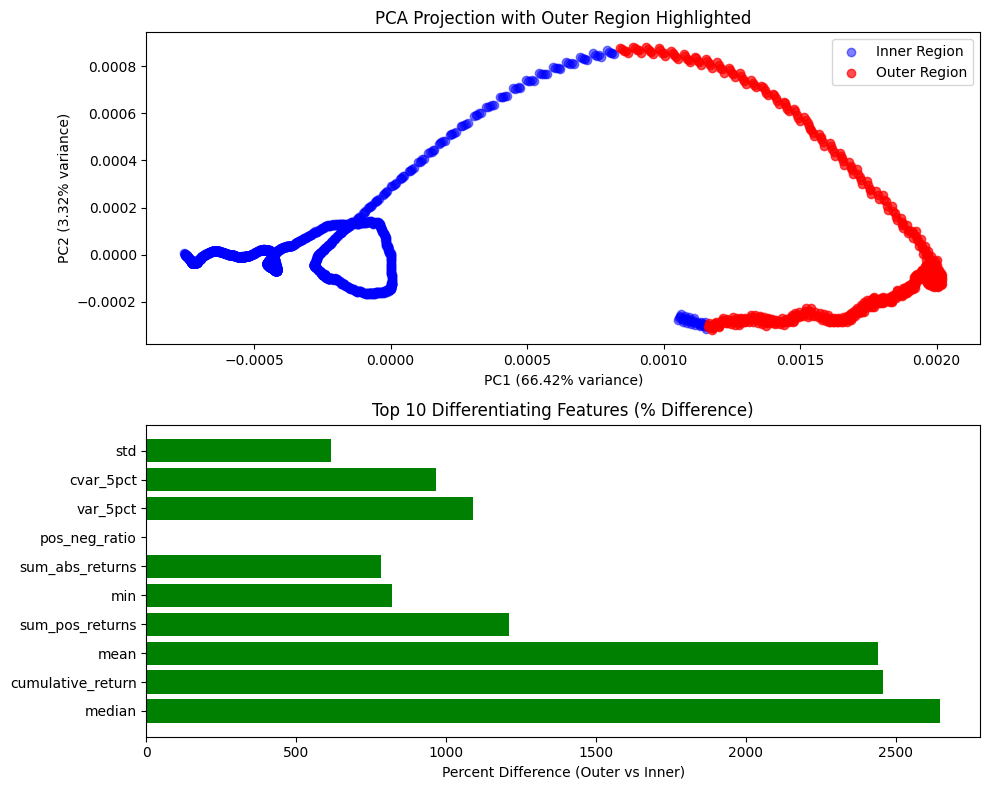

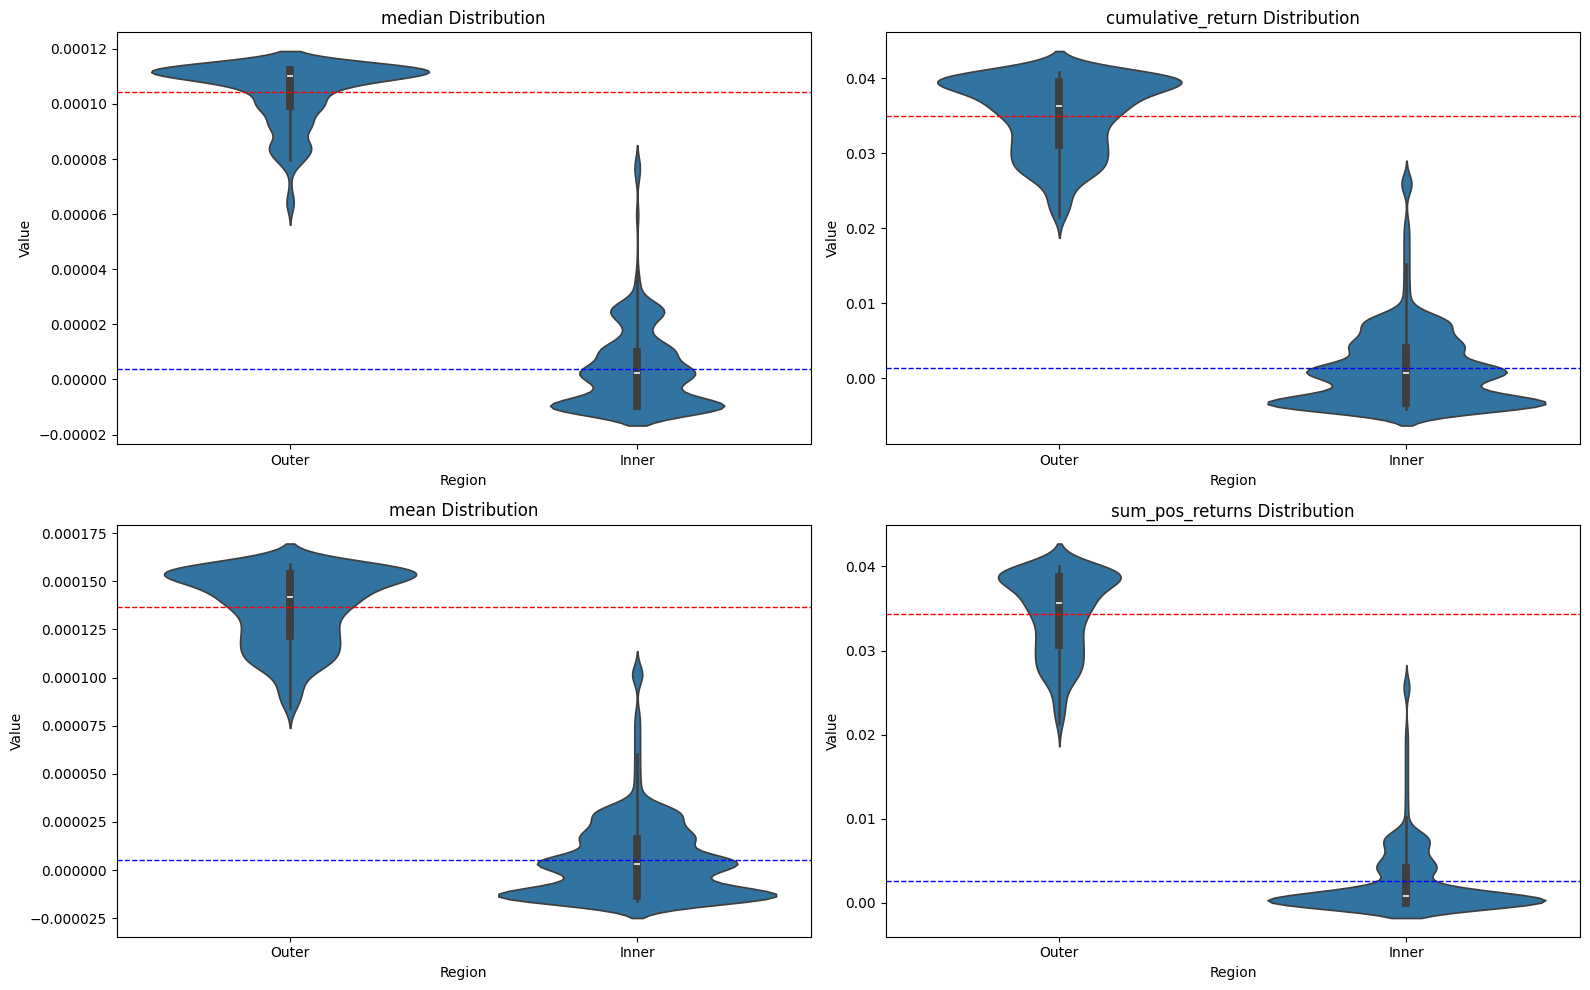

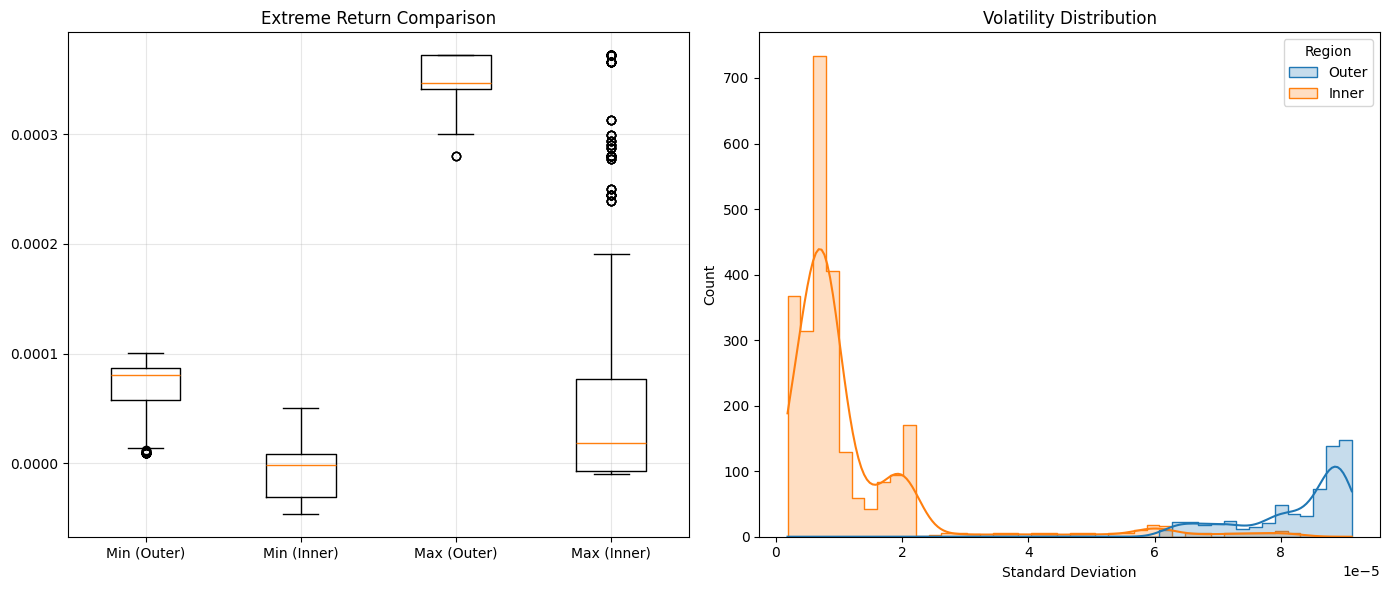

In [5]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

def analyze_outer_region(returns_data, outer_percentile=80):
    """
    Analyze what characterizes the outer region points in PCA projection
    
    Parameters:
    -----------
    returns_data : numpy.ndarray
        Array of shape (n_samples, window_size) containing return sequences
    outer_percentile : int, default=80
        Percentile threshold for defining the outer region
        
    Returns:
    --------
    dict
        Dictionary with analysis results
    """
    # Apply PCA
    pca = PCA(n_components=2)
    projected = pca.fit_transform(returns_data)
    
    # Calculate distances from origin
    distances = np.sqrt(projected[:, 0]**2 + projected[:, 1]**2)
    
    # Determine the threshold for outer region
    threshold = np.percentile(distances, outer_percentile)
    
    # Split data into inner and outer regions
    outer_mask = distances >= threshold
    inner_mask = ~outer_mask
    
    outer_indices = np.where(outer_mask)[0]
    inner_indices = np.where(inner_mask)[0]
    
    outer_returns = returns_data[outer_indices]
    inner_returns = returns_data[inner_indices]
    
    # Calculate statistics
    stats_functions = {
        'mean': lambda x: np.mean(x, axis=1),
        'std': lambda x: np.std(x, axis=1),
        'min': lambda x: np.min(x, axis=1),
        'max': lambda x: np.max(x, axis=1),
        'median': lambda x: np.median(x, axis=1),
        'skewness': lambda x: stats.skew(x, axis=1),
        'kurtosis': lambda x: stats.kurtosis(x, axis=1),
        'cumulative_return': lambda x: np.prod(1 + x, axis=1) - 1,
        'sum_abs_returns': lambda x: np.sum(np.abs(x), axis=1),
        'sum_pos_returns': lambda x: np.sum(np.maximum(0, x), axis=1),
        'sum_neg_returns': lambda x: np.sum(np.minimum(0, x), axis=1),
        'pos_neg_ratio': lambda x: np.sum(x > 0, axis=1) / np.sum(x < 0, axis=1),
    }
    
    # Calculate max drawdown
    def calc_drawdown(x):
        results = []
        for i in range(len(x)):
            returns = x[i]
            cum_returns = np.cumprod(1 + returns)
            running_max = np.maximum.accumulate(cum_returns)
            drawdowns = (cum_returns - running_max) / running_max
            max_drawdown = np.min(drawdowns)
            results.append(max_drawdown)
        return np.array(results)
    
    # Calculate longest streak of negative returns
    def calc_max_neg_streak(x):
        results = []
        for i in range(len(x)):
            returns = x[i]
            streaks = []
            current_streak = 0
            
            for r in returns:
                if r < 0:
                    current_streak += 1
                else:
                    streaks.append(current_streak)
                    current_streak = 0
            
            streaks.append(current_streak)  # Add final streak
            results.append(max(streaks))
        
        return np.array(results)
    
    # Calculate autocorrelation
    def calc_autocorr(x, lag=1):
        results = []
        for i in range(len(x)):
            returns = x[i]
            n = len(returns)
            if lag >= n:
                results.append(0)
                continue
                
            mean = np.mean(returns)
            c0 = np.sum((returns - mean) ** 2) / n
            ct = np.sum((returns[lag:] - mean) * (returns[:n-lag] - mean)) / (n - lag)
            
            if c0 == 0:
                results.append(0)
            else:
                results.append(ct / c0)
        
        return np.array(results)
    
    # Calculate VaR and CVaR (5%)
    def calc_var_cvar(x, percentile=5):
        results_var = []
        results_cvar = []
        
        for i in range(len(x)):
            returns = x[i]
            var = np.percentile(returns, percentile)
            cvar = np.mean(returns[returns <= var])
            results_var.append(var)
            results_cvar.append(cvar)
            
        return np.array(results_var), np.array(results_cvar)
    
    # Add computed statistics to the dictionary
    stats_functions['max_drawdown'] = calc_drawdown
    stats_functions['max_neg_streak'] = calc_max_neg_streak
    stats_functions['autocorr_lag1'] = lambda x: calc_autocorr(x, lag=1)
    
    # Calculate all statistics for both groups
    outer_stats = {name: func(outer_returns) for name, func in stats_functions.items()}
    inner_stats = {name: func(inner_returns) for name, func in stats_functions.items()}
    
    # Calculate VaR and CVaR
    outer_stats['var_5pct'], outer_stats['cvar_5pct'] = calc_var_cvar(outer_returns)
    inner_stats['var_5pct'], inner_stats['cvar_5pct'] = calc_var_cvar(inner_returns)
    
    # Calculate tail ratios
    outer_stats['tail_ratio'] = np.abs(np.percentile(outer_returns, 95, axis=1) / np.percentile(outer_returns, 5, axis=1))
    inner_stats['tail_ratio'] = np.abs(np.percentile(inner_returns, 95, axis=1) / np.percentile(inner_returns, 5, axis=1))
    
    # Calculate average statistics
    avg_outer_stats = {name: np.mean(values) for name, values in outer_stats.items()}
    avg_inner_stats = {name: np.mean(values) for name, values in inner_stats.items()}
    
    # Calculate differences
    diffs = {}
    percent_diffs = {}
    
    for name in avg_outer_stats.keys():
        diffs[name] = avg_outer_stats[name] - avg_inner_stats[name]
        if avg_inner_stats[name] != 0:
            percent_diffs[name] = (diffs[name] / np.abs(avg_inner_stats[name])) * 100
        else:
            percent_diffs[name] = float('inf') if diffs[name] > 0 else float('-inf')
    
    # Sort features by absolute percent difference
    sorted_features = sorted(
        percent_diffs.items(), 
        key=lambda x: abs(x[1]), 
        reverse=True
    )
    
    # Prepare result
    result = {
        'pca_components': pca.components_,
        'pca_explained_variance': pca.explained_variance_ratio_,
        'outer_mask': outer_mask,
        'threshold': threshold,
        'avg_outer_stats': avg_outer_stats,
        'avg_inner_stats': avg_inner_stats,
        'diffs': diffs,
        'percent_diffs': percent_diffs,
        'sorted_features': sorted_features,
        'outer_stats': outer_stats,
        'inner_stats': inner_stats,
        'projected_data': projected
    }
    
    return result

def plot_analysis_results(result, top_n=10):
    """
    Plot the analysis results
    
    Parameters:
    -----------
    result : dict
        The result from analyze_outer_region function
    top_n : int, default=10
        Number of top features to display
    """
    # 1. Create the PCA scatter plot with highlighted outer region
    projected = result['projected_data']
    outer_mask = result['outer_mask']
    
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.scatter(projected[~outer_mask, 0], projected[~outer_mask, 1], 
                color='blue', label='Inner Region', alpha=0.5)
    plt.scatter(projected[outer_mask, 0], projected[outer_mask, 1], 
                color='red', label='Outer Region', alpha=0.7)
    plt.title('PCA Projection with Outer Region Highlighted')
    plt.xlabel(f'PC1 ({result["pca_explained_variance"][0]:.2%} variance)')
    plt.ylabel(f'PC2 ({result["pca_explained_variance"][1]:.2%} variance)')
    plt.legend()
    
    # 2. Plot the top differentiating features
    top_features = result['sorted_features'][:top_n]
    feature_names = [f[0] for f in top_features]
    percent_diffs = [f[1] for f in top_features]
    
    plt.subplot(2, 1, 2)
    colors = ['green' if pd > 0 else 'red' for pd in percent_diffs]
    plt.barh(feature_names, percent_diffs, color=colors)
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.title(f'Top {top_n} Differentiating Features (% Difference)')
    plt.xlabel('Percent Difference (Outer vs Inner)')
    plt.tight_layout()
    
    # 3. Create violin plots for the top 4 features
    top4_features = feature_names[:4]
    plt.figure(figsize=(16, 10))
    
    for i, feature in enumerate(top4_features):
        plt.subplot(2, 2, i+1)
        
        # Prepare data for violin plot
        outer_values = result['outer_stats'][feature]
        inner_values = result['inner_stats'][feature]
        
        # Create DataFrame for seaborn
        df = pd.DataFrame({
            'Value': np.concatenate([outer_values, inner_values]),
            'Region': ['Outer'] * len(outer_values) + ['Inner'] * len(inner_values)
        })
        
        sns.violinplot(x='Region', y='Value', data=df)
        plt.title(f'{feature} Distribution')
        
        # Add means as horizontal lines
        plt.axhline(y=np.mean(outer_values), color='red', linestyle='--', linewidth=1)
        plt.axhline(y=np.mean(inner_values), color='blue', linestyle='--', linewidth=1)
    
    plt.tight_layout()
    
    # 4. Return period analysis
    plt.figure(figsize=(14, 6))
    
    # Create boxplots for min/max returns
    plt.subplot(1, 2, 1)
    min_outer = result['outer_stats']['min']
    min_inner = result['inner_stats']['min']
    max_outer = result['outer_stats']['max']
    max_inner = result['inner_stats']['max']
    
    data = [min_outer, min_inner, max_outer, max_inner]
    labels = ['Min (Outer)', 'Min (Inner)', 'Max (Outer)', 'Max (Inner)']
    
    plt.boxplot(data, labels=labels)
    plt.title('Extreme Return Comparison')
    plt.grid(True, alpha=0.3)
    
    # Create distribution of volatility
    plt.subplot(1, 2, 2)
    
    # Get standard deviations
    std_outer = result['outer_stats']['std']
    std_inner = result['inner_stats']['std']
    
    # Create DataFrame for seaborn
    df_std = pd.DataFrame({
        'Standard Deviation': np.concatenate([std_outer, std_inner]),
        'Region': ['Outer'] * len(std_outer) + ['Inner'] * len(std_inner)
    })
    
    sns.histplot(data=df_std, x='Standard Deviation', hue='Region', 
                 kde=True, element='step', common_norm=False)
    plt.title('Volatility Distribution')
    
    plt.tight_layout()

# Usage example:
result = analyze_outer_region(real_returns, outer_percentile=80)
plot_analysis_results(result)

C:\Users\nicka\AppData\Local\Temp\ipykernel_20732\1876288774.py:69: RuntimeWarning: divide by zero encountered in divide
  'pos_neg_ratio': lambda x: np.sum(x > 0, axis=1) / np.sum(x < 0, axis=1),
c:\Users\nicka\master-thesis\packages\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in scalar subtract
  sqr = _ensure_numeric((avg - values) ** 2)


TypeError: Image data of dtype object cannot be converted to float

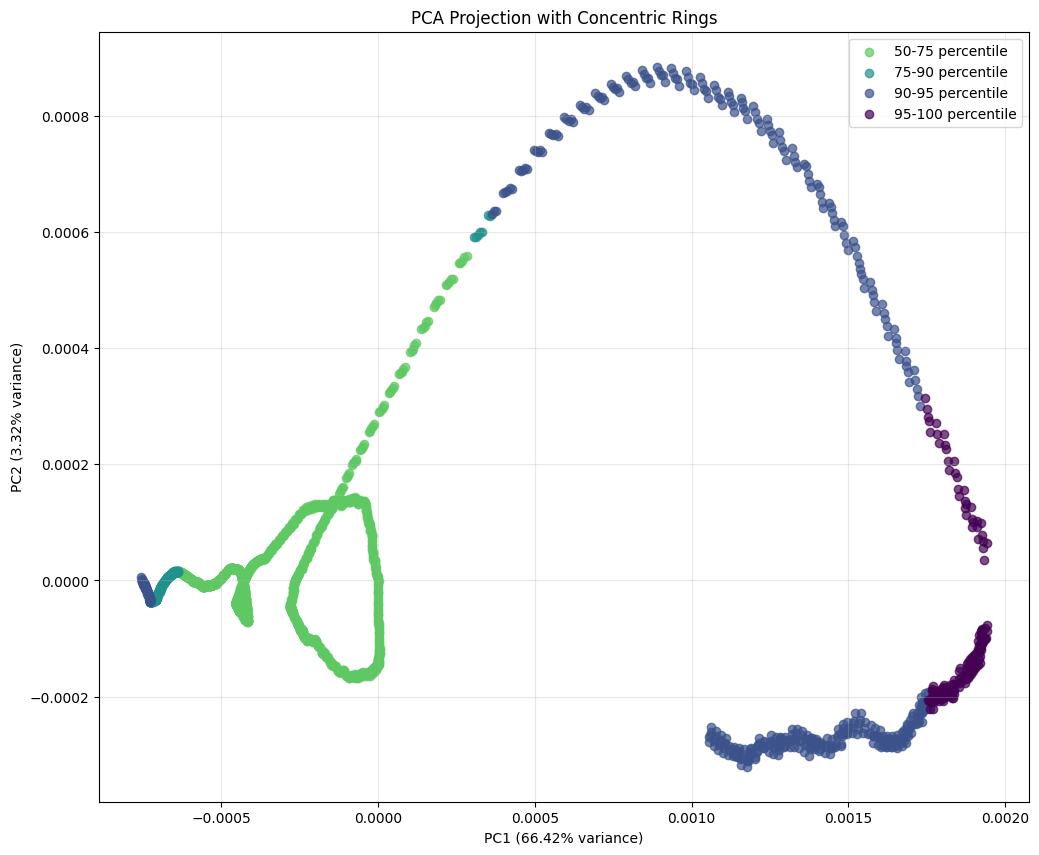

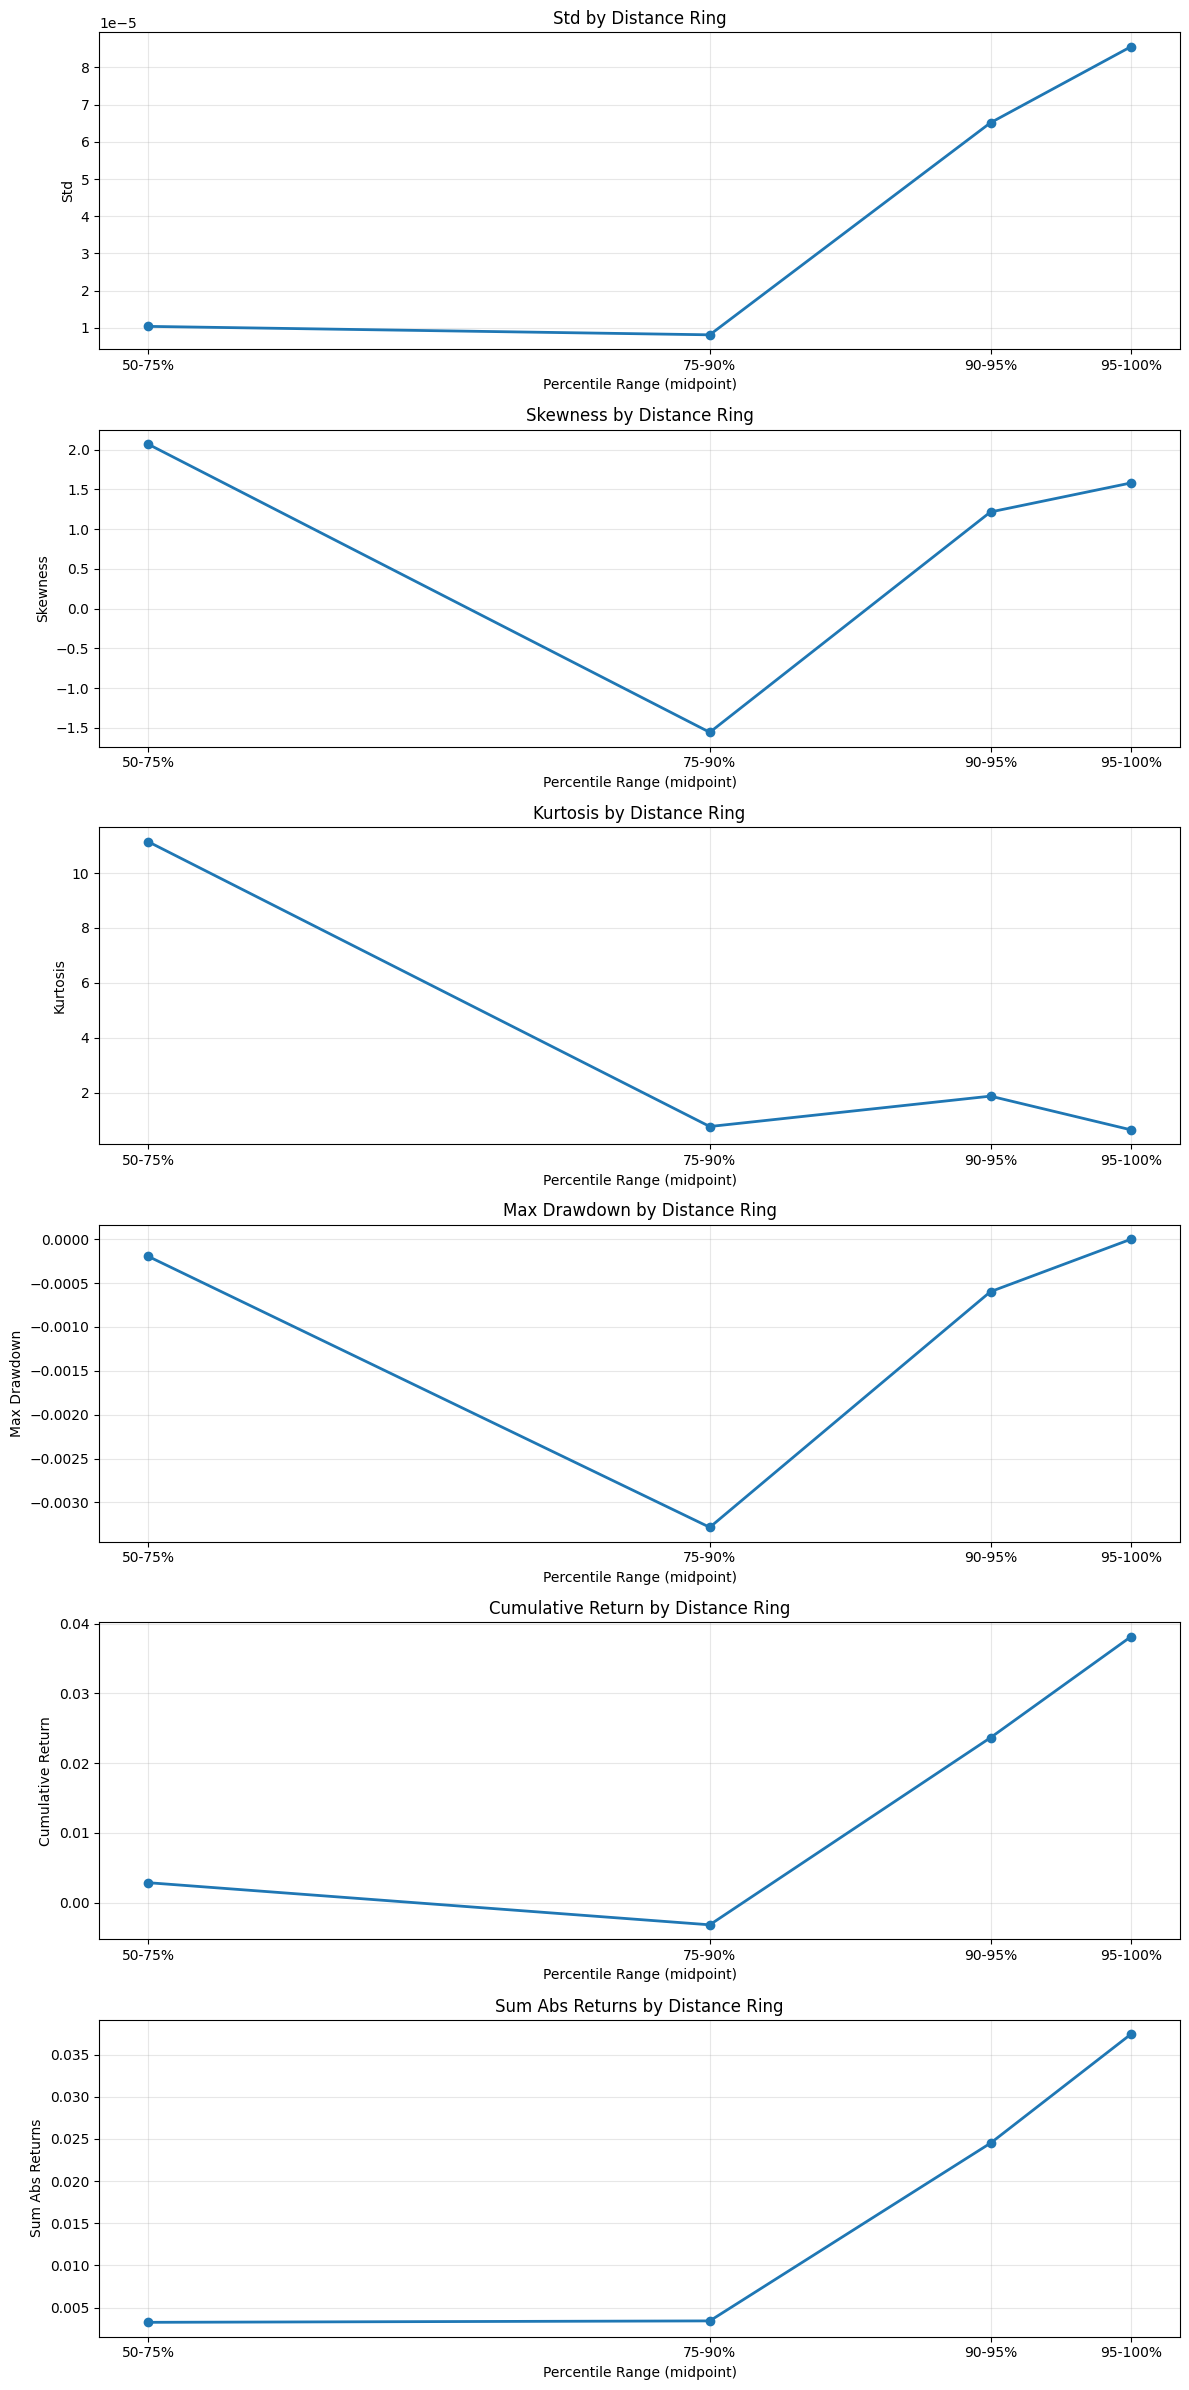

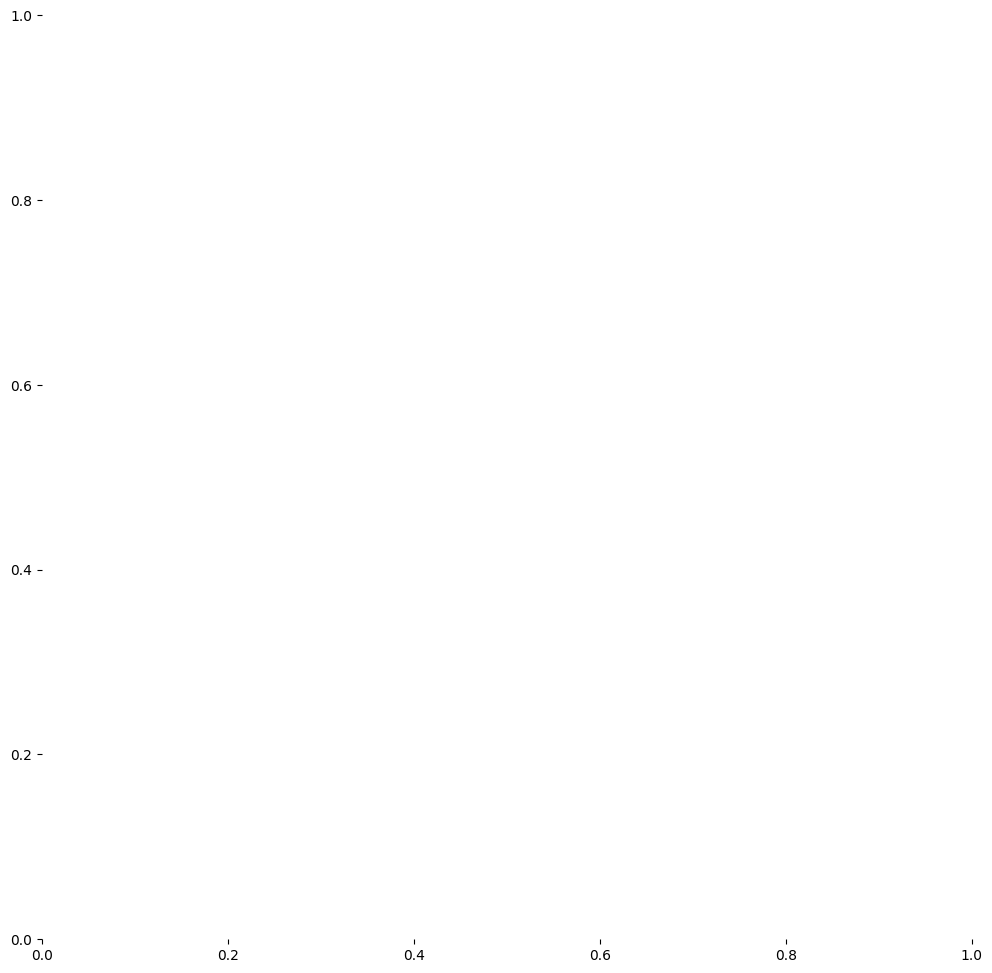

In [6]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from matplotlib.patches import Ellipse
from matplotlib.colors import LinearSegmentedColormap

def analyze_concentric_rings(returns_data, num_rings=5, focus_percentiles=None):
    """
    Analyze data by dividing PCA projection into concentric rings
    
    Parameters:
    -----------
    returns_data : numpy.ndarray
        Array of shape (n_samples, window_size) containing return sequences
    num_rings : int, default=5
        Number of concentric rings to divide the data into
    focus_percentiles : list of tuple, optional
        List of (start, end) percentile ranges to focus on. 
        Example: [(95, 100), (90, 95), (75, 90), (0, 75)]
        
    Returns:
    --------
    dict
        Dictionary with analysis results
    """
    # Apply PCA
    pca = PCA(n_components=2)
    projected = pca.fit_transform(returns_data)
    
    # Calculate distances from origin
    distances = np.sqrt(projected[:, 0]**2 + projected[:, 1]**2)
    
    # If no specific percentiles provided, create equally spaced rings
    if focus_percentiles is None:
        # Create equally spaced percentiles
        step = 100 / num_rings
        percentiles = [(100 - (i+1)*step, 100 - i*step) for i in range(num_rings)]
    else:
        percentiles = focus_percentiles
        num_rings = len(percentiles)
    
    # Calculate thresholds for each ring
    thresholds = [np.percentile(distances, p[0]) for p in percentiles]
    thresholds.append(np.min(distances) - 1e-10)  # Add minimum threshold
    
    # Create masks for each ring
    ring_masks = []
    for i in range(num_rings):
        # Points between the lower and upper threshold
        mask = (distances >= thresholds[i+1]) & (distances < thresholds[i])
        ring_masks.append(mask)
    
    # Calculate statistics
    stats_functions = {
        'mean': lambda x: np.mean(x, axis=1),
        'std': lambda x: np.std(x, axis=1),
        'min': lambda x: np.min(x, axis=1),
        'max': lambda x: np.max(x, axis=1),
        'median': lambda x: np.median(x, axis=1),
        'skewness': lambda x: stats.skew(x, axis=1),
        'kurtosis': lambda x: stats.kurtosis(x, axis=1),
        'cumulative_return': lambda x: np.prod(1 + x, axis=1) - 1,
        'sum_abs_returns': lambda x: np.sum(np.abs(x), axis=1),
        'sum_pos_returns': lambda x: np.sum(np.maximum(0, x), axis=1),
        'sum_neg_returns': lambda x: np.sum(np.minimum(0, x), axis=1),
        'pos_neg_ratio': lambda x: np.sum(x > 0, axis=1) / np.sum(x < 0, axis=1),
    }
    
    # Calculate max drawdown
    def calc_drawdown(x):
        results = []
        for i in range(len(x)):
            returns = x[i]
            cum_returns = np.cumprod(1 + returns)
            running_max = np.maximum.accumulate(cum_returns)
            drawdowns = (cum_returns - running_max) / running_max
            max_drawdown = np.min(drawdowns)
            results.append(max_drawdown)
        return np.array(results)
    
    # Calculate longest streak of negative returns
    def calc_max_neg_streak(x):
        results = []
        for i in range(len(x)):
            returns = x[i]
            streaks = []
            current_streak = 0
            
            for r in returns:
                if r < 0:
                    current_streak += 1
                else:
                    streaks.append(current_streak)
                    current_streak = 0
            
            streaks.append(current_streak)  # Add final streak
            results.append(max(streaks))
        
        return np.array(results)
    
    # Calculate autocorrelation
    def calc_autocorr(x, lag=1):
        results = []
        for i in range(len(x)):
            returns = x[i]
            n = len(returns)
            if lag >= n:
                results.append(0)
                continue
                
            mean = np.mean(returns)
            c0 = np.sum((returns - mean) ** 2) / n
            ct = np.sum((returns[lag:] - mean) * (returns[:n-lag] - mean)) / (n - lag)
            
            if c0 == 0:
                results.append(0)
            else:
                results.append(ct / c0)
        
        return np.array(results)
    
    # Calculate VaR and CVaR (5%)
    def calc_var_cvar(x, percentile=5):
        results_var = []
        results_cvar = []
        
        for i in range(len(x)):
            returns = x[i]
            var = np.percentile(returns, percentile)
            cvar = np.mean(returns[returns <= var])
            results_var.append(var)
            results_cvar.append(cvar)
            
        return np.array(results_var), np.array(results_cvar)
    
    # Add computed statistics to the dictionary
    stats_functions['max_drawdown'] = calc_drawdown
    stats_functions['max_neg_streak'] = calc_max_neg_streak
    stats_functions['autocorr_lag1'] = lambda x: calc_autocorr(x, lag=1)
    
    # Calculate statistics for each ring
    ring_stats = []
    for mask in ring_masks:
        ring_data = returns_data[mask]
        if len(ring_data) == 0:
            # Skip if no data in this ring
            ring_stats.append({})
            continue
            
        # Calculate all defined statistics
        stats_dict = {name: func(ring_data) for name, func in stats_functions.items()}
        
        # Calculate VaR and CVaR
        stats_dict['var_5pct'], stats_dict['cvar_5pct'] = calc_var_cvar(ring_data)
        
        # Calculate tail ratio
        stats_dict['tail_ratio'] = np.abs(np.percentile(ring_data, 95, axis=1) / 
                                         np.percentile(ring_data, 5, axis=1))
        
        ring_stats.append(stats_dict)
    
    # Calculate average statistics for each ring
    avg_ring_stats = []
    for stats_dict in ring_stats:
        if not stats_dict:  # Skip empty dictionaries
            avg_ring_stats.append({})
            continue
            
        avg_dict = {name: np.mean(values) for name, values in stats_dict.items()}
        avg_ring_stats.append(avg_dict)
    
    # Prepare result
    result = {
        'pca_components': pca.components_,
        'pca_explained_variance': pca.explained_variance_ratio_,
        'percentiles': percentiles,
        'thresholds': thresholds,
        'ring_masks': ring_masks,
        'avg_ring_stats': avg_ring_stats,
        'ring_stats': ring_stats,
        'projected_data': projected,
        'distances': distances
    }
    
    return result

def plot_concentric_rings(result, feature_focus=None):
    """
    Plot the concentric rings analysis
    
    Parameters:
    -----------
    result : dict
        The result from analyze_concentric_rings function
    feature_focus : list, optional
        List of feature names to focus on in the comparison plot
    """
    projected = result['projected_data']
    ring_masks = result['ring_masks']
    percentiles = result['percentiles']
    avg_ring_stats = result['avg_ring_stats']
    
    # 1. Create the PCA scatter plot with highlighted rings
    plt.figure(figsize=(12, 10))
    
    # Create viridis-like custom colormap with more distinction
    cmap = plt.cm.viridis
    colors = [cmap(i) for i in np.linspace(0, 1, len(ring_masks))]
    
    # Plot from outer to inner to see outer points better
    for i in range(len(ring_masks)-1, -1, -1):
        mask = ring_masks[i]
        if np.sum(mask) == 0:
            continue
        
        label = f"{percentiles[i][0]}-{percentiles[i][1]} percentile"
        plt.scatter(projected[mask, 0], projected[mask, 1], 
                   color=colors[i], label=label, alpha=0.7)
    
    plt.title('PCA Projection with Concentric Rings')
    plt.xlabel(f'PC1 ({result["pca_explained_variance"][0]:.2%} variance)')
    plt.ylabel(f'PC2 ({result["pca_explained_variance"][1]:.2%} variance)')
    plt.legend(loc='upper right')
    plt.grid(alpha=0.3)
    
    # 2. Plot statistics comparison across rings
    if feature_focus is None:
        # Select some default interesting features if none provided
        feature_focus = ['std', 'skewness', 'kurtosis', 'max_drawdown', 
                         'cumulative_return', 'sum_abs_returns']
    
    # Filter out empty dictionaries
    non_empty_stats = [s for s in avg_ring_stats if s]
    non_empty_percentiles = [p for i, p in enumerate(percentiles) if avg_ring_stats[i]]
    
    if len(non_empty_stats) < 2:
        print("Not enough rings with data for comparison")
        return
    
    # Check if all focused features exist in the stats
    available_features = set(non_empty_stats[0].keys())
    feature_focus = [f for f in feature_focus if f in available_features]
    
    # Prepare data for the line plots
    fig, axes = plt.subplots(len(feature_focus), 1, figsize=(12, 4*len(feature_focus)))
    
    ring_labels = [f"{p[0]}-{p[1]}%" for p in non_empty_percentiles]
    # Use ring center as x value
    x_values = [(p[0] + p[1])/2 for p in non_empty_percentiles]
    
    for i, feature in enumerate(feature_focus):
        ax = axes[i] if len(feature_focus) > 1 else axes
        
        # Extract values for this feature across all rings
        feature_values = [stats[feature] for stats in non_empty_stats]
        
        # Plot line
        ax.plot(x_values, feature_values, 'o-', linewidth=2)
        
        # Add labels and title
        ax.set_xlabel('Percentile Range (midpoint)')
        ax.set_ylabel(feature.replace('_', ' ').title())
        ax.set_title(f'{feature.replace("_", " ").title()} by Distance Ring')
        
        # Add grid
        ax.grid(alpha=0.3)
        
        # Set x-ticks at ring centers
        ax.set_xticks(x_values)
        ax.set_xticklabels(ring_labels)
    
    plt.tight_layout()
    
    # 3. Create heatmap comparing all statistics across rings
    # Get all available statistics
    all_stats = list(non_empty_stats[0].keys())
    all_stats.sort()  # Sort alphabetically
    
    # Create a DataFrame for the heatmap
    stats_df = pd.DataFrame(index=all_stats, columns=ring_labels)
    
    for i, stats in enumerate(non_empty_stats):
        for stat, value in stats.items():
            stats_df.loc[stat, ring_labels[i]] = value
    
    # Calculate percent change from innermost to outermost
    stats_df['% Change'] = ((stats_df[ring_labels[0]] / stats_df[ring_labels[-1]]) - 1) * 100
    
    # Plot the heatmap
    plt.figure(figsize=(12, 12))
    
    # Normalize the data for better visualization
    norm_df = stats_df.copy()
    for col in ring_labels:
        # Z-score normalization along each feature
        norm_df[col] = (stats_df[col] - stats_df[col].mean()) / stats_df[col].std()
    
    # Keep the % Change column unnormalized
    norm_df['% Change'] = stats_df['% Change']
    
    # Create heatmap
    sns.heatmap(norm_df, annot=True, cmap='coolwarm', fmt=".2f", 
                linewidths=0.5, center=0)
    plt.title('Statistical Features Across Distance Rings (Normalized)')
    plt.tight_layout()
    
    # 4. Plot key features specifically for the outermost ring vs innermost
    # Just take the top 6 features by absolute percent change
    top_features = stats_df.iloc[:, -1].abs().sort_values(ascending=False).head(6).index
    
    plt.figure(figsize=(12, 8))
    
    # Create a bar plot
    colors = ['red' if v < 0 else 'green' for v in stats_df.loc[top_features, '% Change']]
    plt.barh(top_features, stats_df.loc[top_features, '% Change'], color=colors)
    
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.title('Top Features: % Difference Between Outermost and Innermost Ring')
    plt.xlabel('Percent Difference')
    plt.ylabel('Feature')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    
    # 5. Visualize the distribution of a few key statistics across rings with violin plots
    key_features = ['std', 'skewness', 'max_drawdown', 'cumulative_return']
    key_features = [f for f in key_features if f in available_features]
    
    if key_features:
        plt.figure(figsize=(15, 10))
        
        for i, feature in enumerate(key_features):
            plt.subplot(2, 2, i+1)
            
            # Prepare data for the violin plot
            violin_data = []
            
            for j, stats in enumerate(result['ring_stats']):
                if not stats:  # Skip empty rings
                    continue
                violin_data.append(stats[feature])
            
            # Create the violin plot
            plt.violinplot(violin_data, showmeans=True, showextrema=True)
            
            # Add labels
            plt.title(f'{feature.replace("_", " ").title()} Distribution by Ring')
            plt.xticks(range(1, len(non_empty_percentiles)+1), ring_labels)
            plt.grid(alpha=0.3)
        
        plt.tight_layout()

def analyze_most_extreme_points(returns_data, top_n=50, visualize_examples=3):
    """
    Analyze the most extreme points in the PCA projection
    
    Parameters:
    -----------
    returns_data : numpy.ndarray
        Array of shape (n_samples, window_size) containing return sequences
    top_n : int, default=50
        Number of most extreme points to analyze
    visualize_examples : int, default=3
        Number of example return sequences to visualize
        
    Returns:
    --------
    dict
        Dictionary with analysis results
    """
    # Apply PCA
    pca = PCA(n_components=2)
    projected = pca.fit_transform(returns_data)
    
    # Calculate distances from origin
    distances = np.sqrt(projected[:, 0]**2 + projected[:, 1]**2)
    
    # Get the indices of the top_n most extreme points
    extreme_indices = np.argsort(distances)[-top_n:]
    
    # Extract the extreme points
    extreme_returns = returns_data[extreme_indices]
    extreme_projected = projected[extreme_indices]
    extreme_distances = distances[extreme_indices]
    
    # Calculate various statistics
    extreme_stats = {
        'mean': np.mean(extreme_returns, axis=1),
        'std': np.std(extreme_returns, axis=1),
        'min': np.min(extreme_returns, axis=1),
        'max': np.max(extreme_returns, axis=1),
        'median': np.median(extreme_returns, axis=1),
        'skewness': stats.skew(extreme_returns, axis=1),
        'kurtosis': stats.kurtosis(extreme_returns, axis=1),
        'cumulative_return': np.prod(1 + extreme_returns, axis=1) - 1
    }
    
    # Calculate max drawdown
    max_drawdowns = []
    for returns in extreme_returns:
        cum_returns = np.cumprod(1 + returns)
        running_max = np.maximum.accumulate(cum_returns)
        drawdowns = (cum_returns - running_max) / running_max
        max_drawdowns.append(np.min(drawdowns))
    extreme_stats['max_drawdown'] = np.array(max_drawdowns)
    
    # Prepare result
    result = {
        'extreme_indices': extreme_indices,
        'extreme_returns': extreme_returns,
        'extreme_projected': extreme_projected,
        'extreme_distances': extreme_distances,
        'extreme_stats': extreme_stats,
        'projected_data': projected,
        'distances': distances
    }
    
    # Visualization
    
    # 1. PCA Projection highlighting extreme points
    plt.figure(figsize=(12, 10))
    
    # Plot all points
    plt.scatter(projected[:, 0], projected[:, 1], 
               color='blue', label='All Points', alpha=0.2)
    
    # Highlight extreme points
    plt.scatter(extreme_projected[:, 0], extreme_projected[:, 1], 
               color='red', label=f'Top {top_n} Extreme Points', alpha=0.7)
    
    plt.title('PCA Projection with Most Extreme Points Highlighted')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # 2. Visualize example return sequences
    if visualize_examples > 0:
        # Pick a few examples to visualize (select ones that are maximally different)
        example_indices = []
        
        # First example is the most extreme
        example_indices.append(extreme_indices[-1])
        
        # For additional examples, try to pick ones that are different from each other
        if visualize_examples > 1:
            # Pick examples by angle in PCA space
            angles = np.arctan2(extreme_projected[:, 1], extreme_projected[:, 0])
            sorted_by_angle = np.argsort(angles)
            
            # Choose points that are roughly equally spaced by angle
            for i in range(1, visualize_examples):
                idx = sorted_by_angle[i * len(sorted_by_angle) // visualize_examples]
                example_indices.append(extreme_indices[idx])
        
        plt.figure(figsize=(15, 4 * visualize_examples))
        
        for i, idx in enumerate(example_indices):
            plt.subplot(visualize_examples, 1, i + 1)
            
            time_axis = np.arange(returns_data.shape[1])
            returns = returns_data[idx]
            cumulative = np.cumprod(1 + returns) - 1
            
            # Plot returns
            plt.plot(time_axis, returns, 'b-', alpha=0.5, label='Daily Returns')
            
            # Plot cumulative returns on secondary y-axis
            ax2 = plt.gca().twinx()
            ax2.plot(time_axis, cumulative * 100, 'r-', label='Cumulative Return (%)')
            
            # Stats to display
            cum_return = cumulative[-1] * 100
            max_dd = np.min((np.cumprod(1 + returns) / np.maximum.accumulate(np.cumprod(1 + returns))) - 1) * 100
            vol = np.std(returns) * 100 * np.sqrt(252)  # Annualized
            
            # Add title with stats
            plt.title(f'Example {i+1}: Cum Return = {cum_return:.1f}%, '
                     f'Max Drawdown = {max_dd:.1f}%, '
                     f'Annualized Vol = {vol:.1f}%, '
                     f'Distance = {distances[idx]:.4f}')
            
            # Add legends
            plt.gca().legend(loc='upper left')
            ax2.legend(loc='upper right')
            
            plt.grid(alpha=0.3)
        
        plt.tight_layout()
    
    # 3. Summary statistics for extreme points
    plt.figure(figsize=(12, 8))
    
    # Create violin plots for key statistics
    key_features = ['cumulative_return', 'max_drawdown', 'std', 'skewness']
    
    for i, feature in enumerate(key_features):
        plt.subplot(2, 2, i+1)
        
        data = extreme_stats[feature]
        
        # Create violin plot
        parts = plt.violinplot([data], showmeans=True, showextrema=True)
        
        # Add a scatter plot overlay for individual points
        x = np.random.normal(1, 0.05, size=len(data))
        plt.scatter(x, data, alpha=0.5, color='blue')
        
        # Add median and mean lines
        plt.axhline(y=np.median(data), color='r', linestyle='-', alpha=0.3)
        plt.axhline(y=np.mean(data), color='g', linestyle='-', alpha=0.3)
        
        # Add labels
        plt.title(f'{feature.replace("_", " ").title()} of Extreme Points')
        plt.xticks([1], ['Extreme Points'])
        plt.grid(alpha=0.3)
    
    plt.tight_layout()
    
    return result

# Usage example:
# Define percentile focus for concentric rings - focus on the outer rings
focus_percentiles = [(95, 100), (90, 95), (75, 90), (50, 75), (0, 50)]
result = analyze_concentric_rings(real_returns, focus_percentiles=focus_percentiles)
plot_concentric_rings(result)

# For the most extreme points:
extreme_result = analyze_most_extreme_points(real_returns, top_n=50, visualize_examples=3)